In [1]:
import numpy as np
import KTCFwd
import KTCMeshing
import KTCRegularization
import KTCPlotting
import KTCScoring
import KTCAux
import matplotlib.pyplot as plt
import scipy as sp

# Replace MakePaths with appropriate imports
# from your_library import create2Dmesh_circ, setMeasurementPattern, simulateConductivity, EITFEM, SMprior, sigmaplotter, interpolateRecoToPixGrid, Otsu, Otsu2, scoringFunction

# number of distinct types of segments (2 = background, one type of inclusion)
# (3 = background, two types of inclusions)
segments = 3

# set up data simulation mesh
Nel = 32  # number of electrodes
#Mesh2sim, Meshsim,elcenterangles = KTCMeshing.create2Dmesh_circ(Nel, 6, 1, 1)

# load premade finite element mesh (made using Gmsh, exported to Matlab and saved into a .mat file)
mat_dict_mesh = sp.io.loadmat('Mesh_dense.mat')
g = mat_dict_mesh['g'] #node coordinates
H = mat_dict_mesh['H'] #indices of nodes making up the triangular elements
elfaces = mat_dict_mesh['elfaces'][0].tolist() #indices of nodes making up the boundary electrodes

#Element structure
ElementT = mat_dict_mesh['Element']['Topology'].tolist()
for k in range(len(ElementT)):
    ElementT[k] = ElementT[k][0].flatten()
ElementE = mat_dict_mesh['ElementE'].tolist() #marks elements which are next to boundary electrodes
for k in range(len(ElementE)):
    if len(ElementE[k][0]) > 0:
        ElementE[k] = [ElementE[k][0][0][0], ElementE[k][0][0][1:len(ElementE[k][0][0])]]
    else:
        ElementE[k] = []

#Node structure
NodeC = mat_dict_mesh['Node']['Coordinate']
NodeE = mat_dict_mesh['Node']['ElementConnection'] #marks which elements a node belongs to
nodes = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC]
for k in range(NodeC.shape[0]):
    nodes[k].ElementConnection = NodeE[k][0].flatten()
elements = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT]
for k in range(len(ElementT)):
    elements[k].Electrode = ElementE[k]

#2nd order mesh data
H2 = mat_dict_mesh['H2']
g2 = mat_dict_mesh['g2']
elfaces2 = mat_dict_mesh['elfaces2'][0].tolist()
ElementT2 = mat_dict_mesh['Element2']['Topology']
ElementT2 = ElementT2.tolist()
for k in range(len(ElementT2)):
    ElementT2[k] = ElementT2[k][0].flatten()
ElementE2 = mat_dict_mesh['Element2E']
ElementE2 = ElementE2.tolist()
for k in range(len(ElementE2)):
    if len(ElementE2[k][0]) > 0:
        ElementE2[k] = [ElementE2[k][0][0][0], ElementE2[k][0][0][1:len(ElementE2[k][0][0])]]
    else:
        ElementE2[k] = []

NodeC2 = mat_dict_mesh['Node2']['Coordinate']  # ok
NodeE2 = mat_dict_mesh['Node2']['ElementConnection']  # ok
nodes2 = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC2]
for k in range(NodeC2.shape[0]):
    nodes2[k].ElementConnection = NodeE2[k][0].flatten()
elements2 = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT2]
for k in range(len(ElementT2)):
    elements2[k].Electrode = ElementE2[k]

Meshsim = KTCMeshing.Mesh(H,g,elfaces,nodes,elements)
Mesh2sim = KTCMeshing.Mesh(H2,g2,elfaces2,nodes2,elements2)

# measurement pattern
z = np.ones((Nel, 1))  # contact impedances
Inj, Mpat, vincl = KTCAux.setMeasurementPattern(Nel)  # current injection pattern and voltage measurement pattern


<Figure size 800x600 with 0 Axes>

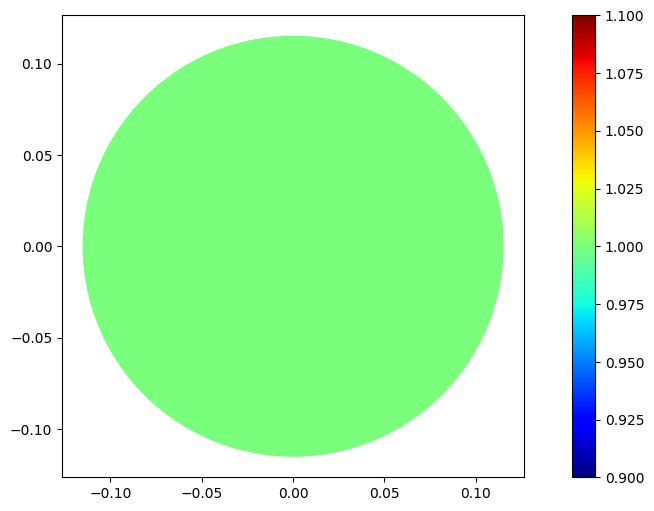

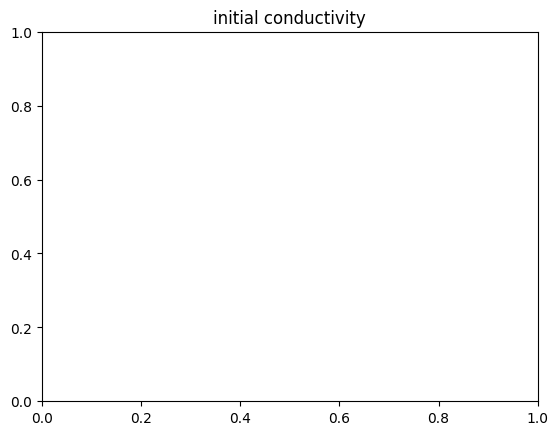

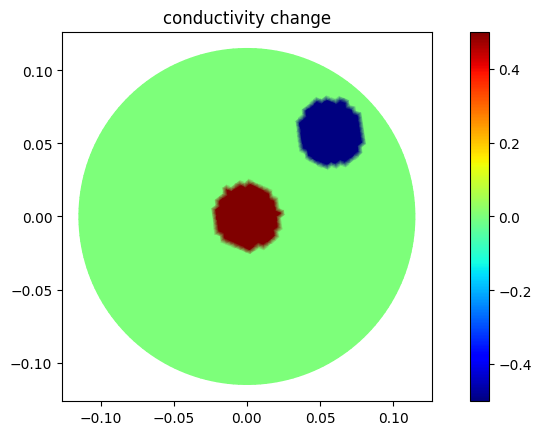

In [20]:
# simulated initial conductivity and the change
sigma, delta_sigma, sigma2 = KTCAux.simulateConductivity(Meshsim, segments)
sgplot = KTCPlotting.SigmaPlotter(Meshsim, [2, 3], 'jet')
sgplot.basic2Dplot(sigma, delta_sigma, ['initial conductivity', 'conductivity change'])

# set up forward solver
solver = KTCFwd.EITFEM(Mesh2sim, Inj, Mpat, vincl)

In [21]:
# simulate data
Iel2_true = solver.SolveForward(sigma, z)
Iel_true = solver.SolveForward(sigma + delta_sigma, z)

# add some noise
noise_std1 = 0.1  # standard deviation of the noise as percentage of each voltage measurement
noise_std2 = 0  # 0.01; %standard deviation of 2nd noise component (this is proportional to the largest measured value)
solver.SetInvGamma(noise_std1, noise_std2, Iel2_true)  # compute the noise precision matrix
tmp = np.random.randn(Iel2_true.shape[0])
Iel2_noisy = Iel2_true # + solver.InvLn * np.random.randn(Iel2_true.shape[0],1)
Iel_noisy = Iel_true # + solver.InvLn * np.random.randn(Iel_true.shape[0],1)
deltaI = Iel_noisy - Iel2_noisy

# create inversion mesh
#Mesh2, Mesh, elcenterangles = KTCMeshing.create2Dmesh_circ(Nel, 5, 1, 4)

# load premade finite element mesh (made using Gmsh, exported to Matlab and saved into a .mat file)
mat_dict_mesh = sp.io.loadmat('Mesh_sparse.mat')
g = mat_dict_mesh['g'] #node coordinates
H = mat_dict_mesh['H'] #indices of nodes making up the triangular elements
elfaces = mat_dict_mesh['elfaces'][0].tolist() #indices of nodes making up the boundary electrodes

#Element structure
ElementT = mat_dict_mesh['Element']['Topology'].tolist()
for k in range(len(ElementT)):
    ElementT[k] = ElementT[k][0].flatten()
ElementE = mat_dict_mesh['ElementE'].tolist() #marks elements which are next to boundary electrodes
for k in range(len(ElementE)):
    if len(ElementE[k][0]) > 0:
        ElementE[k] = [ElementE[k][0][0][0], ElementE[k][0][0][1:len(ElementE[k][0][0])]]
    else:
        ElementE[k] = []

#Node structure
NodeC = mat_dict_mesh['Node']['Coordinate']
NodeE = mat_dict_mesh['Node']['ElementConnection'] #marks which elements a node belongs to
nodes = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC]
for k in range(NodeC.shape[0]):
    nodes[k].ElementConnection = NodeE[k][0].flatten()
elements = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT]
for k in range(len(ElementT)):
    elements[k].Electrode = ElementE[k]

#2nd order mesh data
H2 = mat_dict_mesh['H2']
g2 = mat_dict_mesh['g2']
elfaces2 = mat_dict_mesh['elfaces2'][0].tolist()
ElementT2 = mat_dict_mesh['Element2']['Topology']
ElementT2 = ElementT2.tolist()
for k in range(len(ElementT2)):
    ElementT2[k] = ElementT2[k][0].flatten()
ElementE2 = mat_dict_mesh['Element2E']
ElementE2 = ElementE2.tolist()
for k in range(len(ElementE2)):
    if len(ElementE2[k][0]) > 0:
        ElementE2[k] = [ElementE2[k][0][0][0], ElementE2[k][0][0][1:len(ElementE2[k][0][0])]]
    else:
        ElementE2[k] = []

NodeC2 = mat_dict_mesh['Node2']['Coordinate']  # ok
NodeE2 = mat_dict_mesh['Node2']['ElementConnection']  # ok
nodes2 = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC2]
for k in range(NodeC2.shape[0]):
    nodes2[k].ElementConnection = NodeE2[k][0].flatten()
elements2 = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT2]
for k in range(len(ElementT2)):
    elements2[k].Electrode = ElementE2[k]

Mesh = KTCMeshing.Mesh(H,g,elfaces,nodes,elements)
Mesh2 = KTCMeshing.Mesh(H2,g2,elfaces2,nodes2,elements2)


print(f'Nodes in simulation 1st order mesh: {len(Meshsim.g)}')
print(f'Nodes in inversion 1st order mesh: {len(Mesh.g)}')


c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Nodes in simulation 1st order mesh: 3766
Nodes in inversion 1st order mesh: 1602


In [ ]:
# set up the Gaussian smoothness prior for conductivity change
sigma0 = np.ones((len(Mesh.g), 1))
corrlength = 1 * 0.115
var_sigma = 0.05**2
mean_sigma = sigma0
smprior = KTCRegularization.SMPrior(Mesh.g, corrlength, var_sigma, mean_sigma)

# set up the forward solver for inversion
solver = KTCFwd.EITFEM(Mesh2, Inj, Mpat, vincl)
solver.SetInvGamma(noise_std1, noise_std2, deltaI)

# compute linear difference reconstruction for the conductivity change
J = solver.Jacobian(sigma0, z)
HtLtLH = J.T @ solver.InvGamma_n @ J
RtR = smprior.L.T @ smprior.L
Ht = J.T @ solver.InvGamma_n
deltareco = np.linalg.solve(J.T @ solver.InvGamma_n @ J + smprior.L.T @ smprior.L, J.T @ solver.InvGamma_n @ deltaI)
sgplot = KTCPlotting.SigmaPlotter(Mesh, [5], 'jet')
sgplot.basic2Dplot(deltareco,[], ['linear difference reconstruction'])

# interpolate the reconstruction into a pixel image
deltareco_pixgrid = KTCAux.interpolateRecoToPixGrid(deltareco, Mesh)
fig, ax = plt.subplots()
cax = ax.imshow(deltareco_pixgrid)
plt.colorbar(cax)
plt.axis('image')

# threshold the image histogram using Otsu's method
if segments == 2:
    level, x = KTCScoring.Otsu(deltareco_pixgrid.flatten(), 256, 7)
elif segments == 3:
    level, x =  KTCScoring.Otsu2(deltareco_pixgrid.flatten(), 256, 7)

deltareco_pixgrid_segmented = np.zeros_like(deltareco_pixgrid)
if segments == 2:
    ind = deltareco_pixgrid < x[level[0]]
    deltareco_pixgrid_segmented[ind] = 1
elif segments == 3:
    ind = deltareco_pixgrid < x[level[0]]
    deltareco_pixgrid_segmented[ind] = 1
    ind = deltareco_pixgrid > x[level[1]]
    deltareco_pixgrid_segmented[ind] = 2

fig, ax = plt.subplots()
cax = ax.imshow(deltareco_pixgrid_segmented, cmap='gray')
plt.colorbar(cax)
plt.axis('image')
plt.title('segmented linear difference reconstruction')

fig, ax = plt.subplots()
cax = ax.imshow(deltareco_pixgrid, cmap='gray')
plt.colorbar(cax)
plt.axis('image')

Now we run a reconstruction from the data: